# Troisième partie : Simulation pour déterminer la fréquence nécessaire de mise à jour du                                           modèle de segmentation

## Sommaire

### Importation des modules utilisés

### Chargement du dataset

### Réaliser un PCA pour réduire la dimension de notre jeu de données

- Réduire les données à 4 dimensions principales

- La proportion de variance des données d'origine expliquée par chaque composante principale

- Projection des données sur les 2 premières composantes principales

- Projection des données sur la première et la troisième composantes principales

### Entrainer nos modèles de clustering

- Observer nos modèles sur durées de 90 jours en fonction du score ARI

- Une distribution des scores ARI par modèle

- Déterminer pendant combien de temps nos modèles restent pertinents

- Une représentation graphique de chaque modèle au fil du temps

### Observer le modèle le plus adapté ( KMeans ) aux données

- Une représentation graphique du score ARI pour le modèle K-Means

### Importation des modules utilisés

In [1]:
# Importation des librairies
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn import decomposition

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from tabulate import tabulate
import os

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Chargement du dataset

In [2]:
df_new_indicators = pd.read_csv('./data/df_new_indicators.csv')

In [4]:
df_new_indicators.copy()

,customer_unique_id,price,distance_km_customer_seller,duree_de_livraison,payment_type_encoded,product_category_name_encoded
0,84b5012d933ff251917aa48ff80739f0,269.00,8.975321,7,1,21
1,84b5012d933ff251917aa48ff80739f0,269.00,8.975321,7,1,21
2,84b5012d933ff251917aa48ff80739f0,269.00,8.975321,7,1,21
3,84b5012d933ff251917aa48ff80739f0,269.00,8.975321,7,1,21
4,84b5012d933ff251917aa48ff80739f0,269.00,8.975321,7,1,21
...,...,...,...,...,...,...
129772,02eedc8f54686a4ce9df86a5a4b6e30e,29.99,1538.777880,14,2,18
129773,02eedc8f54686a4ce9df86a5a4b6e30e,29.99,1538.349687,14,2,18
129774,02eedc8f54686a4ce9df86a5a4b6e30e,29.99,1539.080912,14,2,18
129775,02eedc8f54686a4ce9df86a5a4b6e30e,29.99,1538.556447,14,2,18


In [5]:
sorted_values = sorted(df_new_indicators['duree_de_livraison'].unique())
sorted_values

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 22,
 23,
 24,
 27,
 28,
 33,
 35,
 37,
 42,
 43]

### Réaliser un PCA pour réduire la dimension de notre jeu de données

In [5]:
# Selection des colonnes utiles pour la suite 
columns = ['price', 'distance_km_customer_seller', 'duree_de_livraison', 'payment_type_encoded', 'product_category_name_encoded']

# Créer une copie du DataFrame avec les colonnes sélectionnées 
df_new_indicators = df_new_indicators[columns]

In [6]:
# transformer les données en array numpy
X = df_new_indicators.values

In [7]:
# Mettre à l'échelle les données numériques
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

- Réduire les données à 4 dimensions principales

In [8]:
pca = decomposition.PCA(n_components=4)
pca.fit(X_scaled)

PCA(n_components=4)

- La proportion de variance des données d'origine expliquée par chaque composante principale

In [9]:
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.30208139 0.23236398 0.20874271 0.16186227]
0.9050503582805037


Les 3 premières composantes principales expliquent plus de 90% des des données

- Projection des données sur les 2 premières composantes principales

Text(0, 0.5, 'PC 2')

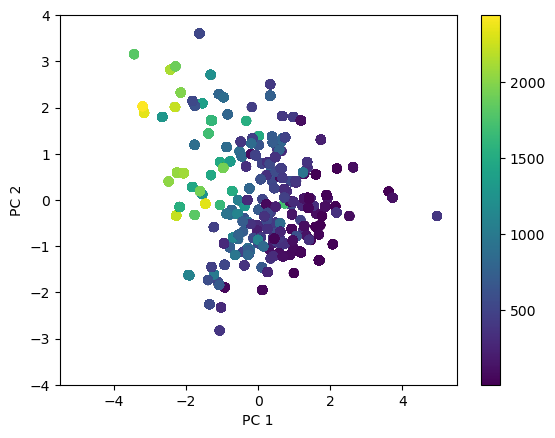

In [10]:
# projeter X sur les composantes principales
X_projected = pca.transform(X_scaled)

# afficher chaque observation
plt.scatter(X_projected[:, 0], X_projected[:, 1],
    # colorer en utilisant la variable 'distance_km_customer_seller'
    c=df_new_indicators.distance_km_customer_seller)

plt.xlim([-5.5, 5.5])
plt.ylim([-4, 4])
plt.colorbar()
plt.xlabel('PC 1')
plt.ylabel('PC 2')

- Projection des données sur la première et la troisième composantes principales

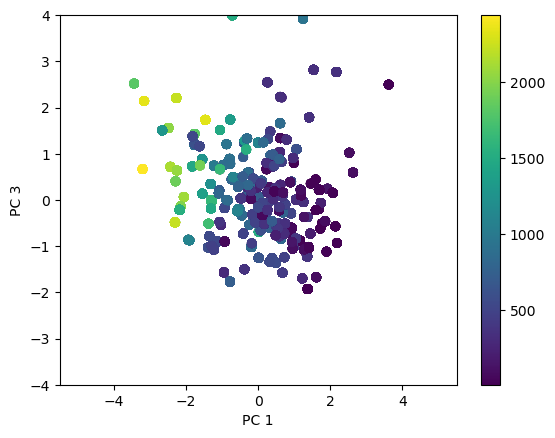

In [11]:
# Projeter X sur les composantes principales
X_projected = pca.transform(X_scaled)

# Afficher chaque observation
plt.scatter(X_projected[:, 0], X_projected[:, 2],
            # Colorer en utilisant la variable 'distance_km_customer_seller'
            c=df_new_indicators.distance_km_customer_seller)

plt.xlim([-5.5, 5.5])
plt.ylim([-4, 4])
plt.colorbar()
plt.xlabel('PC 1')
plt.ylabel('PC 3')
plt.savefig('PCA_PC1_PC3.png')
plt.show()

Les clients et les vendeurs les plus proches (points violet foncé) sont plutôt situées dans la partie droite du graphe (PC1 > 0) et les moins proches (points jaunes) plutôt dans la partie gauche (PC1 < 0).

- Graphique des vecteurs propres

Text(0, 0.5, 'PC 2')

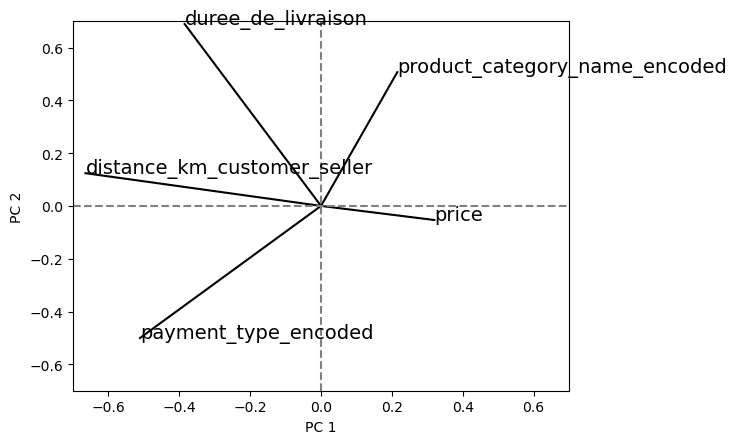

In [12]:
pcs = pca.components_

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    # Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Afficher le nom (data.columns[i]) de la performance
    plt.text(x, y, df_new_indicators.columns[i], fontsize='14')

# Afficher une ligne horizontale y=0
plt.plot([-0.7, 0.7], [0, 0], color='grey', ls='--')

# Afficher une ligne verticale x=0
plt.plot([0, 0], [-0.7, 0.7], color='grey', ls='--')

plt.xlim([-0.7, 0.7])
plt.ylim([-0.7, 0.7])
plt.xlabel('PC 1')
plt.ylabel('PC 2')

### Entrainer nos modèles de clustering

- Entrainement des modèles en utlisant un échantillonnage et le PCA pour réduire les données

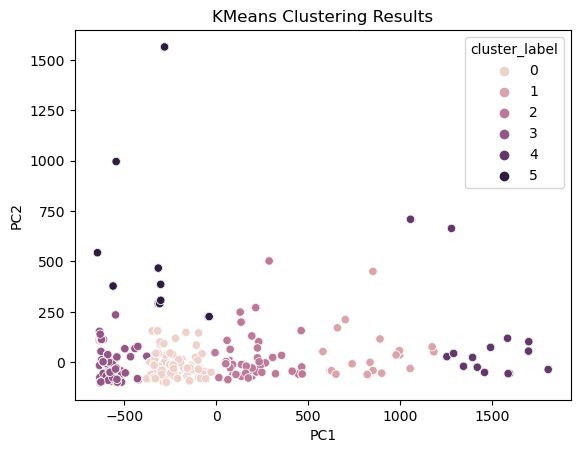

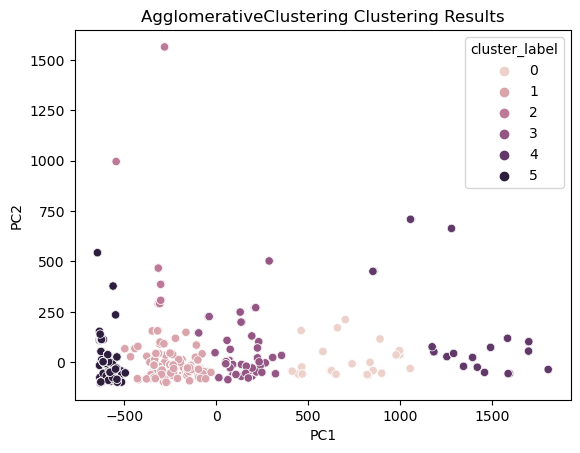

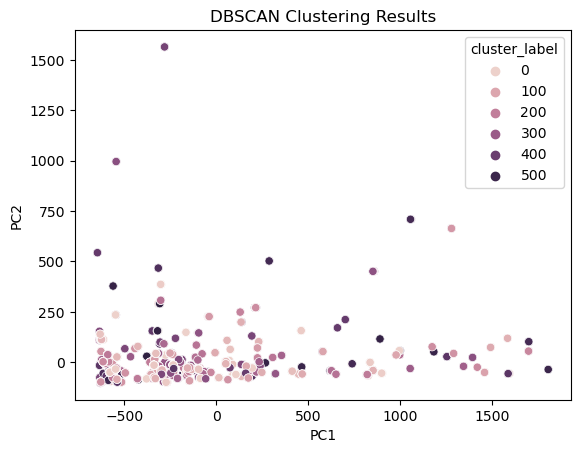

Silhouette Score - K-Means: 0.5812894942992509
Silhouette Score - Agglomerative Clustering: 0.5413261069633521
Silhouette Score - DBSCAN: 0.9726785593055937


In [34]:
# Sélectionner les colonnes à utiliser pour l'entraînement du modèle de clustering
columns = ['price', 'distance_km_customer_seller', 'duree_de_livraison', 'payment_type_encoded', 'product_category_name_encoded']

# Réduire la taille du jeu de données
sample_data = df_new_indicators.sample(n=50000)  # Sélectionner un échantillon aléatoire de 50000 lignes
reduced_data = sample_data[columns]

# Réduire la taille du jeu de données avec PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(reduced_data)

# Créer un DataFrame avec les composantes principales
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])

# Définir les modèles de clustering à utiliser
models = {
    'K-Means': KMeans(n_clusters=6),
    'Agglomerative Clustering': AgglomerativeClustering(n_clusters=6),
    'DBSCAN': DBSCAN(eps=0.3, min_samples=5)
}

# Créer une fonction pour l'entraînement et l'évaluation d'un modèle de clustering
def train_and_evaluate_model(model, data, columns):
    # Entraîner le modèle sur les données
    model.fit(data)

    # Prédire les clusters
    cluster_labels = model.labels_

    # Ajouter les labels de cluster au DataFrame des composantes principales
    df_pca['cluster_label'] = cluster_labels

    # Analyse visuelle
    sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster_label')
    plt.title(f'{model.__class__.__name__} Clustering Results')
    plt.show()
    
    # Sauvegarder l'analyse visuelle 
    save_path = f'{model.__class__.__name__}_clustering.png'
    plt.savefig(save_path)
    plt.close()

    # Calculer le Silhouette Score
    if len(set(cluster_labels)) > 1:
        silhouette_avg = silhouette_score(data, cluster_labels)
    else:
        silhouette_avg = -1

    return silhouette_avg

# Effectuer l'entraînement et l'évaluation pour chaque modèle de clustering
results = {}
for model_name, model in models.items():
    silhouette_avg = train_and_evaluate_model(model, df_pca, columns)
    results[model_name] = silhouette_avg

# Afficher les résultats
for model_name, silhouette_avg in results.items():
    print(f"Silhouette Score - {model_name}: {silhouette_avg}")

- Entrainement des modèles en utlisant un échantillonnage et le T-SNE pour réduire les données

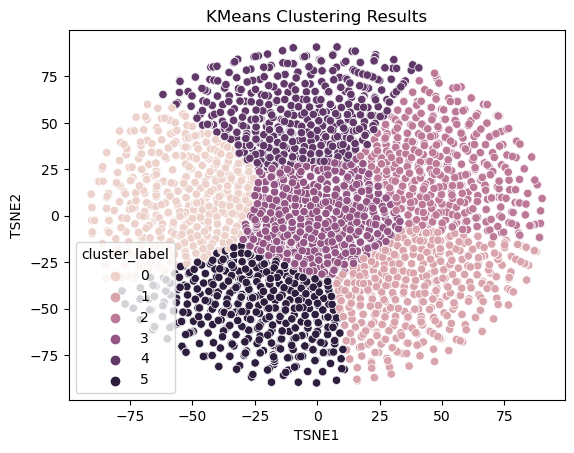

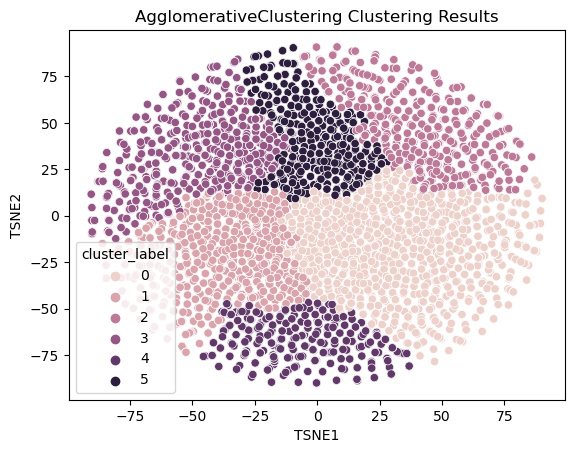

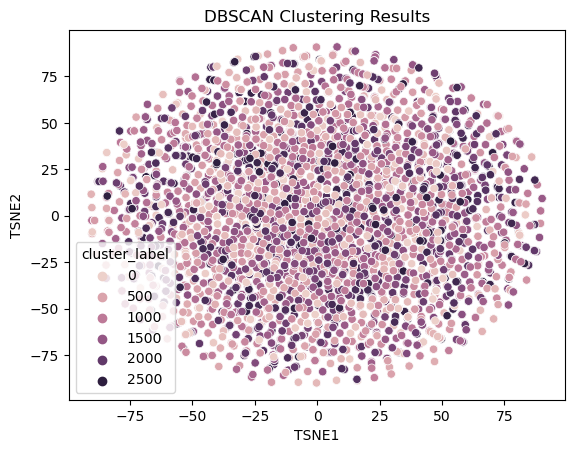

Silhouette Score - K-Means: 0.35386896366276754
Silhouette Score - Agglomerative Clustering: 0.26517142996554166
Silhouette Score - DBSCAN: 0.973433270494349


In [36]:
# Sélectionner les colonnes à utiliser pour l'entraînement du modèle de clustering
columns = ['price', 'distance_km_customer_seller', 'duree_de_livraison', 'payment_type_encoded', 'product_category_name_encoded']

# Réduire la taille du jeu de données
sample_data = df_new_indicators.sample(n=50000)  # Sélectionner un échantillon aléatoire de 50000 lignes
reduced_data = sample_data[columns]

# Réduire la taille du jeu de données avec t-SNE
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(reduced_data)

# Créer un DataFrame avec les coordonnées t-SNE
df_tsne = pd.DataFrame(data_tsne, columns=['TSNE1', 'TSNE2'])

# Définir les modèles de clustering à utiliser
models = {
    'K-Means': KMeans(n_clusters=6),
    'Agglomerative Clustering': AgglomerativeClustering(n_clusters=6),
    'DBSCAN': DBSCAN(eps=0.3, min_samples=6)
}

# Créer une fonction pour l'entraînement et l'évaluation d'un modèle de clustering
def train_and_evaluate_model(model, data, columns):
    # Entraîner le modèle sur les données
    model.fit(data)

    # Prédire les clusters
    cluster_labels = model.labels_
    ..

    # Ajouter les labels de cluster au DataFrame des coordonnées t-SNE
    df_tsne['cluster_label'] = cluster_labels

    # Analyse visuelle
    plt.figure()
    sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='cluster_label')
    plt.title(f'{model.__class__.__name__} Clustering Results')
    plt.show()

    # Sauvegarder l'analyse visuelle 
    save_path = f'{model.__class__.__name__}_clustering.png'
    plt.savefig(save_path)
    plt.close()

    # Calculer le Silhouette Score
    if len(set(cluster_labels)) > 1:
        silhouette_avg = silhouette_score(data, cluster_labels)
    else:
        silhouette_avg = -1

    return silhouette_avg

# Effectuer l'entraînement et l'évaluation pour chaque modèle de clustering
results = {}
for model_name, model in models.items():
    silhouette_avg = train_and_evaluate_model(model, df_tsne, columns)
    results[model_name] = silhouette_avg

# Afficher les résultats
for model_name, silhouette_avg in results.items():
    print(f"Silhouette Score - {model_name}: {silhouette_avg}")

### Déterminer au bout de combien de temps le modèle de clustering devient obsolète et nécessite d'être ré-entraîné

- Observer nos modèles sur durées de 90 jours en fonction des scores ARI

In [13]:
# Sélectionner les colonnes à utiliser pour l'entraînement du modèle de clustering
columns = ['price', 'distance_km_customer_seller', 'duree_de_livraison', 'payment_type_encoded', 'product_category_name_encoded']

# Réduire la taille du jeu de données avec t-SNE
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(df_new_indicators[columns])

# Créer un DataFrame avec les coordonnées t-SNE
df_tsne = pd.DataFrame(data_tsne, columns=['TSNE1', 'TSNE2'])

# Définir les modèles de clustering à utiliser
models = {
    'K-Means': KMeans(n_clusters=5),
    'Agglomerative Clustering': AgglomerativeClustering(n_clusters=5),
    'DBSCAN': DBSCAN(eps=0.3, min_samples=5)
}

# Créer une fonction pour l'entraînement et l'évaluation d'un modèle de clustering
def train_and_evaluate_model(model, data, columns):
    scores = []
    for day in range(1, 90):  # Boucle sur une période de 90 jours
        # Sélectionner les données pour le jour actuel
        day_data = data[:day]

        # Vérifier si le nombre de jours est suffisant pour entraîner le modèle
        if day >= model.n_clusters if hasattr(model, 'n_clusters') else day >= model.min_samples:
            # Entraîner le modèle sur les données du jour actuel
            cluster_labels = model.fit_predict(day_data)
        else:
            cluster_labels = [-1] * day  # Aucun cluster si le nombre de jours est insuffisant

        # Calculer le score ARI
        ari = adjusted_rand_score(data_tsne[:day, 0], cluster_labels)  # Utiliser la première dimension de t-SNE pour le calcul du score

        scores.append(ari)

    return scores

# Effectuer l'entraînement et l'évaluation pour chaque modèle de clustering
results = {}
for model_name, model in models.items():
    scores = train_and_evaluate_model(model, df_tsne.values, columns)
    results[model_name] = scores

# Afficher les résultats sous forme de tableau
table_data = []
for model_name, scores in results.items():
    table_data.append([model_name] + scores)

headers = ['Modèle'] + [f'Jour {day}' for day in range(1, 90)]

table = tabulate(table_data, headers=headers, tablefmt='psql')
plt.savefig('table_performances.png')
print(table)

+--------------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+---------

<Figure size 640x480 with 0 Axes>

- Une distribution des scores ARI par modèle

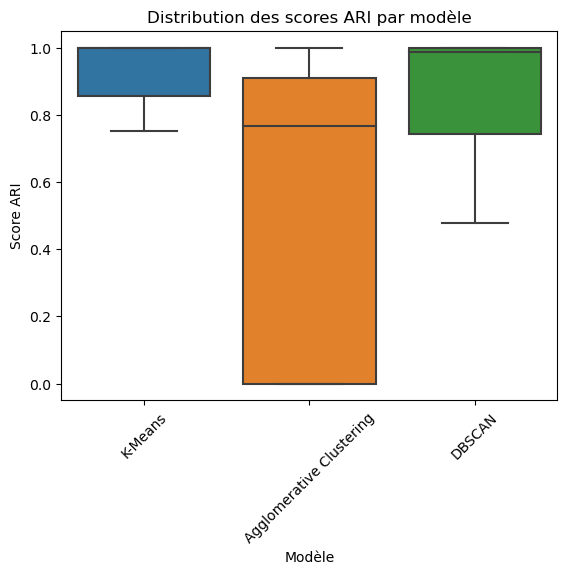

In [14]:
# Créer un DataFrame avec les scores ARI de chaque modèle
df_scores = pd.DataFrame(results)

# Tracer un graphique en boîte pour comparer les scores ARI
sns.boxplot(data=df_scores)
plt.xlabel('Modèle')
plt.ylabel('Score ARI')
plt.title('Distribution des scores ARI par modèle')
plt.xticks(rotation=45)
plt.show()

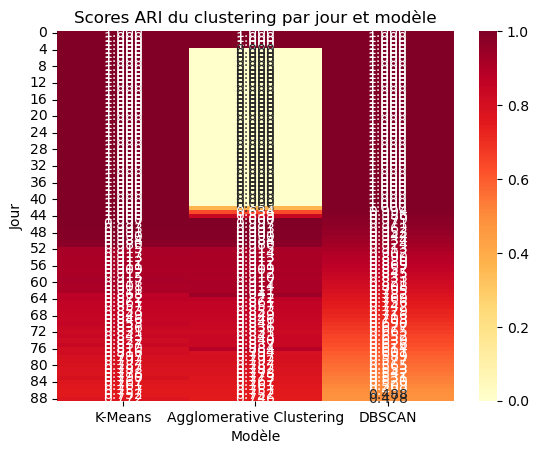

In [16]:
scores_array = np.array(list(results.values())).T

ax = sns.heatmap(scores_array, cmap='YlOrRd', annot=True, fmt='.3f', xticklabels=list(results.keys()))
ax.set_xlabel('Modèle')
ax.set_ylabel('Jour')
ax.set_title('Scores ARI du clustering par jour et modèle')
plt.show()

- Déterminer pendant combien de temps nos modèles restent pertinents

In [44]:
# Effectuer l'entraînement et l'évaluation pour chaque modèle de clustering
results = {}
retrain_periods = {}  # Dictionnaire pour enregistrer les périodes de ré-entraînement

for model_name, model in models.items():
    scores = train_and_evaluate_model(model, df_tsne.values, columns)
    results[model_name] = scores

    # Vérifier si le score ARI tombe en-dessous de 0.8
    retrain_period = next((i for i, score in enumerate(scores) if score < 0.8), None)

    if retrain_period is not None:
        retrain_periods[model_name] = retrain_period

# Afficher les résultats sous forme de tableau
table_data = []
for model_name, scores in results.items():
    table_data.append([model_name] + scores)

headers = ['Modèle'] + [f'Jour {day}' for day in range(1, 90)]

table = tabulate(table_data, headers=headers, tablefmt='fancy_grid')
print(table)

# Afficher les périodes de ré-entraînement
if retrain_periods:
    print("Périodes de ré-entraînement nécessaires :")
    for model_name, period in retrain_periods.items():
        print(f"Modèle {model_name} : Jour {period + 1}")
else:
    print("Aucune ré-entraînement nécessaire.")

╒══════════════════════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═════════

- Une représentation graphique de chaque modèle au fil du temps

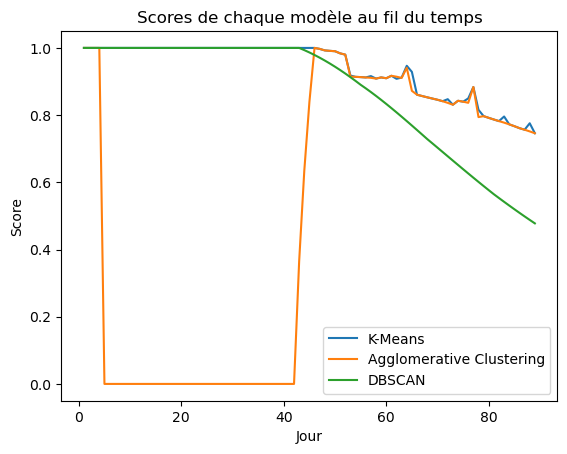

In [46]:
# Obtention des scores de chaque modèle
model_names = list(results.keys())
model_scores = list(results.values())

# Tracer les graphiques de ligne pour chaque modèle
for i in range(len(model_names)):
    plt.plot(range(1, 90), model_scores[i], label=model_names[i])

# Ajouter les légendes et les étiquettes
plt.xlabel('Jour')
plt.ylabel('Score')
plt.title('Scores de chaque modèle au fil du temps')
plt.legend()
plt.show()

### Observer le modèle le plus adapté ( KMeans ) aux données

In [49]:
# Sélectionner les colonnes à utiliser pour l'entraînement du modèle de clustering
columns = ['price', 'distance_km_customer_seller', 'duree_de_livraison', 'payment_type_encoded', 'product_category_name_encoded']

# Réduire la taille du jeu de données avec t-SNE
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(df_new_indicators[columns])

# Créer un DataFrame avec les coordonnées t-SNE
df_tsne = pd.DataFrame(data_tsne, columns=['TSNE1', 'TSNE2'])

# Définir le modèle de clustering K-Means
model = KMeans(n_clusters=5)

# Entraîner et évaluer le modèle de clustering K-Means
scores = []
for day in range(1, 90):  # Boucle sur une période de 90 jours
    # Sélectionner les données pour le jour actuel
    day_data = df_tsne.values[:day]

    # Vérifier si le nombre de jours est suffisant pour entraîner le modèle
    if day >= model.n_clusters:
        # Entraîner le modèle sur les données du jour actuel
        fit_model = model.fit(day_data)
        cluster_labels = fit_model.labels_
    else:
        cluster_labels = [-1] * day  # Aucun cluster si le nombre de jours est insuffisant

    # Calculer le score ARI
    ari = adjusted_rand_score(data_tsne[:day, 0], cluster_labels)  # Utiliser la première dimension de t-SNE pour le calcul du score

    scores.append(ari)

# Afficher les résultats sous forme de tableau
table_data = [['K-Means'] + scores]

headers = ['Modèle'] + [f'Jour {day}' for day in range(1, 90)]

table = tabulate(table_data, headers=headers, tablefmt='fancy_grid')
print(table)

╒══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═

In [52]:
# Définir le modèle de clustering K-Means
model = KMeans(n_clusters=5)

def train_and_evaluate_model(model, data, columns):
    scores = []
    for day in range(1, 90):
        day_data = data[:day]

        if day >= model.n_clusters:
            fit_model = model.fit(day_data)
            cluster_labels = fit_model.labels_
        else:
            cluster_labels = [-1] * day

        ari = adjusted_rand_score(data_tsne[:day, 0], cluster_labels)
        scores.append(ari)

    return scores

# Effectuer l'entraînement et l'évaluation du modèle de clustering
scores = train_and_evaluate_model(model, df_tsne.values, columns)

# Afficher les résultats sous forme de tableau
table_data = [['K-Means'] + scores]
headers = ['Modèle'] + [f'Jour {day}' for day in range(1, 90)]
table = tabulate(table_data, headers=headers, tablefmt='fancy_grid')
print(table)

# Vérifier si une période de ré-entraînement est nécessaire
retrain_period = next((i for i, score in enumerate(scores) if score < 0.8), None)

# Afficher la période de ré-entraînement si nécessaire
if retrain_period is not None:
    print(f"Période de ré-entraînement nécessaire pour le modèle K-Means : Jour {retrain_period + 1}")
else:
    print("Aucune ré-entraînement nécessaire pour le modèle K-Means.")

╒══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═

- Une représentation graphique du score ARI pour le modèle K-Means

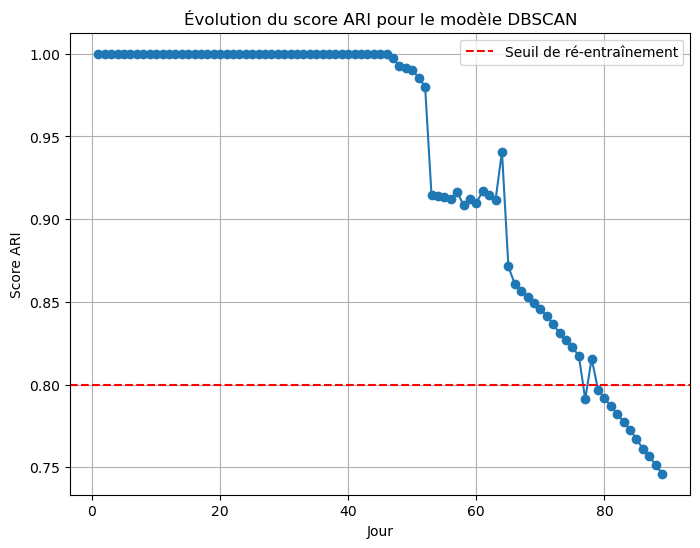

In [53]:
# Graphique des scores ARI
plt.figure(figsize=(8, 6))
plt.plot(range(1, 90), scores, marker='o')
plt.axhline(y=0.8, color='r', linestyle='--', label='Seuil de ré-entraînement')
plt.xlabel('Jour')
plt.ylabel('Score ARI')
plt.title(f'Évolution du score ARI pour le modèle {model_name}')
plt.legend()
plt.grid(True)

# Enregistrer le graphique
save_path = f'{model_name}_ARI_scores.png'
plt.savefig(save_path)

# Afficher le graphique
plt.show()

## Conclusion

En conclusion, malgré la nature inhabituelle des jeux de données avec seulement 3% des clients ayant effectué plus d'une commande, notre analyse comparative a révélé que le modèle K-Means était le plus performant actuellement. Cependant, afin de maintenir la haute performance de l'algorithme, nous recommandons un contrat de maintenance d'une durée de deux mois et demi. Cette approche garantira que le modèle reste précis et adapté aux besoins de l'entreprise. Nous sommes convaincus que cette solution permettra d'optimiser les performances et de fournir des résultats de qualité supérieure pour soutenir la prise de décision et les stratégies marketing.
